# Context

Recent studies have shown that breast cancer continues to be the leading cause of death among women over the world. If detected at an early stage, it can be cured in 9 out of 10 cases.

Automated detection and segmentation of cells from images are the crucial and fundamental steps for the measurement of cellular morphology that is crucial for brest cancer diagnosis and prognosis.


In this notebook, you will learn how to train a segmentation as UNet with **monai** - a framwork based Pytorch Stadard for healthcare imaging.

## Monai

MONAI is a pytorch based open source AI framework launched by NVIDIA and King’s College London.
It is integrated with training and modelling workflows in a native PyTorch Standard. t several places.


Install monai

In [1]:
!pip install monai > /dev/null

Check the installation by running the following cell

In [2]:
import monai
monai.config.print_config()

/home/alex/Desktop/health/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.4.1rc1+5.g996e876e
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 996e876e7542f683508aa04e74b97e284bbde72b
MONAI __file__: /home/<username>/Desktop/health/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 11.1.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.20.1+cu124
tqdm version: 4.67.1
lmdb version: 1.5.1
psutil version: 6.1.1
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: 2.19.0
pynrrd version: 1.1.1
clearml version: 1.17.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



#  Dataset

To train a model, we need to prepare some ingredients:

1. Dataset
2. Model
3. Loss function
4. Optimizer

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os

# I. Create Dataset

There are two ways to create your dataset:
- with pytorch Dataset
- with monai.data.Dataset.

In this exercise, we will create our dataset using torch.utils.data.Dataset.

## 1. List all files in folder

Download the dataset from https://zenodo.org/record/1175282#.YMn_Qy-FDox

Notice that there are two kind of folder : original cell picture folder and mask folders. Using your file explorer or some code, display one image and the corresponding image

In [4]:
!unzip TNBC_NucleiSegmentation.zip

Archive:  TNBC_NucleiSegmentation.zip
   creating: TNBC_NucleiSegmentation/
   creating: TNBC_NucleiSegmentation/GT_01/
  inflating: TNBC_NucleiSegmentation/GT_01/01_1.png  
   creating: __MACOSX/
   creating: __MACOSX/TNBC_NucleiSegmentation/
   creating: __MACOSX/TNBC_NucleiSegmentation/GT_01/
  inflating: __MACOSX/TNBC_NucleiSegmentation/GT_01/._01_1.png  
  inflating: TNBC_NucleiSegmentation/GT_01/01_2.png  
  inflating: __MACOSX/TNBC_NucleiSegmentation/GT_01/._01_2.png  
  inflating: TNBC_NucleiSegmentation/GT_01/01_3.png  
  inflating: __MACOSX/TNBC_NucleiSegmentation/GT_01/._01_3.png  
  inflating: TNBC_NucleiSegmentation/GT_01/01_4.png  
  inflating: __MACOSX/TNBC_NucleiSegmentation/GT_01/._01_4.png  
  inflating: TNBC_NucleiSegmentation/GT_01/01_5.png  
  inflating: __MACOSX/TNBC_NucleiSegmentation/GT_01/._01_5.png  
  inflating: TNBC_NucleiSegmentation/GT_01/01_6.png  
  inflating: __MACOSX/TNBC_NucleiSegmentation/GT_01/._01_6.png  
  inflating: TNBC_NucleiSegmentation/GT_01/

In [5]:
gt = 'TNBC_NucleiSegmentation/GT_01/01_1.png'
img = 'TNBC_NucleiSegmentation/Slide_01/01_1.png'

image = Image.open(img)
gt_image = Image.open(gt)

### Testing image loading

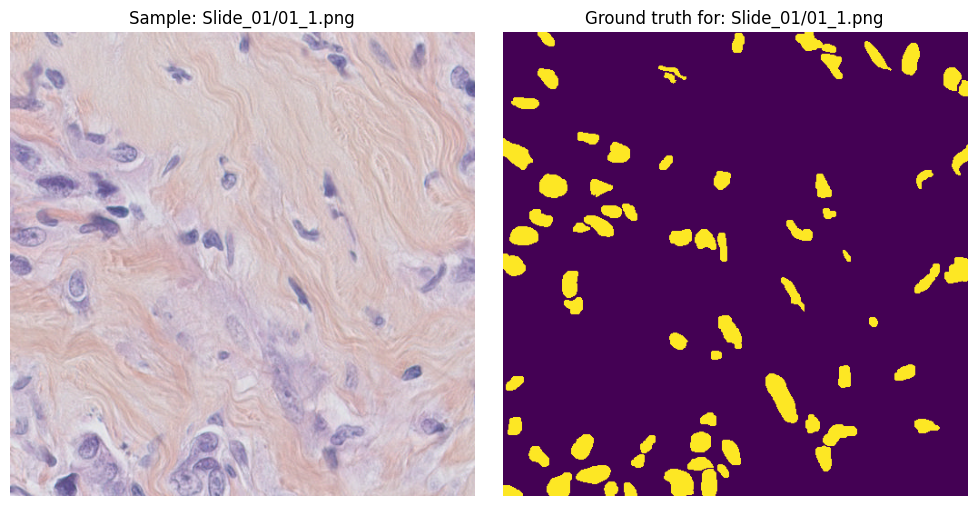

In [6]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Sample: Slide_01/01_1.png")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gt_image)
plt.title("Ground truth for: Slide_01/01_1.png")
plt.axis('off')

plt.tight_layout()
plt.show()

## 2. Define a transform
When you load your data, you need to define some transformation. For example, we want to convert image to the format [num_channels, spatial_dim_1, spatial_dim_2] because monai/pytorch use this format. We'll also need to convert the images to PyTorch tensors with transforms.ToTensor()

The following code lets you load image and the labels and define several steps to transform the data.


In [7]:
import torch

from monai.transforms import Compose, LoadImage, EnsureChannelFirst, ToTensor, NormalizeIntensity
from monai.transforms import ScaleIntensity

from monai.data import PILReader

image_trans = Compose(
    [
        LoadImage(image_only=True, reader = PILReader(converter=lambda image: image.convert("RGB"))),
        EnsureChannelFirst(),
        NormalizeIntensity(),
        ToTensor(),
    ])


label_trans = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        ToTensor(),
    ])


## 3. Create dataset

The following class CellDataset allows us to create our dataset from "image_files" and "label_files" where:
- "image_files" is a list of image names
- "label_files" is the list of segmentation names respectively.

"im_trans" and "label_trans" are respectively the transforms for the images and their labels.




In [8]:
class CellDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, label_files, im_trans, label_trans):
        self.image_files = image_files
        self.label_files = label_files
        self.im_trans = im_trans
        self.label_trans = label_trans

    def __len__(self):
        return(len(self.image_files))

    def __getitem__(self, index):
        return self.im_trans(self.image_files[index]), self.label_trans(self.label_files[index])

By using this class, create your training dataset et your test dataset. Remember to check if your dataset is loaded correctly.

In [9]:
image_files = sorted(glob.glob("TNBC_NucleiSegmentation/Slide_*/*.png"))
label_files = sorted(glob.glob("TNBC_NucleiSegmentation/GT_*/*.png"))

In [10]:
train_size = round(len(image_files) * 0.7)

train_dataset = CellDataset(image_files[:train_size], label_files[:train_size], image_trans, label_trans)
test_dataset = CellDataset(image_files[train_size:], label_files[train_size:], image_trans, label_trans)

print(f"The length of train dataset is: {len(train_dataset)}")
print(f"The length of test dataset is: {len(test_dataset)}")

The length of train dataset is: 35
The length of test dataset is: 15


## 4. DataLoader

With the your dataset loaded, you have to pass it to a DataLoader. The torch.utils.data.DataLoader takes a dataset and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.


The following code let you create a data loader for the train dataset, do the same to create a test_loader on the test_dataset. Name it **test_load**


In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

## 5. Now, time to check your dataloader.

Execute the code following to check if your dataloader works correctly

In [12]:
import monai
im, seg = monai.utils.misc.first(train_loader)
im.shape, im.max(), seg.max()

(torch.Size([4, 3, 512, 512]), metatensor(2.9366), metatensor(1.))

# II. Build your segmentation model with monai

Monai already has a UNet model architecture : https://docs.monai.io/en/stable/networks.html#unet

By using the monai.networks.nets module, build a UNet model for segmentation task in 2D. You'll have to choose the following parameters for the model:

1. dimensions (number of spatial dimensions)
2. in_channels (number of input channel)
3. out_channels (number of output channel)
4. channels
5. strides


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from monai.networks.nets import UNet

model = UNet(
    spatial_dims=2, # 2D images
    in_channels=3,  # RGB input
    out_channels=1, # Binary segmentation mask
    channels=(16, 32, 64, 128), # Feature channels at each level
    strides=(2, 2, 2), # Downsampling factors
)

print("Device:", device)

Device: cuda


# III. Define your loss function and optimizer

For a segmentation prob, we usually use DiceLoss.
Using monai.losses.DiceLoss, define your loss function and store it in the variable named **loss_function**. The option sigmoid = True should be used.




In [14]:
from monai.losses import DiceLoss

loss_function = DiceLoss(sigmoid=True)

With torch.optim, define an optimizer for your model. Use the Adam optimiser



In [15]:
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

# IV. Trainning the model

This time, we have all ingredients to train a segmentation model: a model, an optimizer, train_loader and a loss function.  

Monai use a standard PyTorch program style for training a deep learning model.


The general process with Monai/Pytorch just for one learning step  as follows:

1. Load input and label of each batch.

2. Zero accumulated gradients with optimizer.zero_grad()

3. Compute the output from the model

4. Calculate the loss

5. Perform backprop with loss.backward()

6. Update the optimizer with optimizer.step()


Complete the following code so that it do the training


In [16]:
epoch_loss_values = list()
epoch_val_losses = list()
model = model.to(device)

for epoch in range(30):
    step = 0
    epoch_loss = 0
    model.train()

    for batch_data in train_loader:
        step += 1

        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()

        # compute the model predictions using the model variable and inputs
        predictions = model(inputs)

        # compute the loss using the loss function, the predictions and labels
        loss = loss_function(predictions, labels)

        # use the backward method of the loss variable to  compute the gradient of the loss used to find the minimum of the loss function
        loss.backward()

        # call the step method of the optimizer
        optimizer.step()

        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        print(f"{step}/{epoch_len + 1} | train_loss: {loss.item():.4f}")

    # ADDING validation phase (for finals comparision graphics)
    # ===
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch_data in test_loader:
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            outputs = model(inputs)
            val_loss += loss_function(outputs, labels).item()


        avg_val_loss = val_loss / len(test_loader)
    # ===

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    epoch_val_losses.append(avg_val_loss)
    print(f"=== End of epoch {epoch + 1} | average train_loss: {epoch_loss:.4f}, average test_loss: {avg_val_loss:.4f} ===\n")


1/9 | train_loss: 0.8708
2/9 | train_loss: 0.8341
3/9 | train_loss: 0.7812
4/9 | train_loss: 0.7412
5/9 | train_loss: 0.8436
6/9 | train_loss: 0.8136
7/9 | train_loss: 0.6906
8/9 | train_loss: 0.7374
9/9 | train_loss: 0.6324
=== End of epoch 1 | average train_loss: 0.7717, average test_loss: 0.7158 ===

1/9 | train_loss: 0.6138
2/9 | train_loss: 0.6094
3/9 | train_loss: 0.9465
4/9 | train_loss: 0.8036
5/9 | train_loss: 0.7529
6/9 | train_loss: 0.5749
7/9 | train_loss: 0.6546
8/9 | train_loss: 0.7237
9/9 | train_loss: 0.6200
=== End of epoch 2 | average train_loss: 0.6999, average test_loss: 0.6821 ===

1/9 | train_loss: 0.7874
2/9 | train_loss: 0.7049
3/9 | train_loss: 0.6703
4/9 | train_loss: 0.7396
5/9 | train_loss: 0.7115
6/9 | train_loss: 0.6346
7/9 | train_loss: 0.4945
8/9 | train_loss: 0.6840
9/9 | train_loss: 0.6347
=== End of epoch 3 | average train_loss: 0.6735, average test_loss: 0.6578 ===

1/9 | train_loss: 0.7529
2/9 | train_loss: 0.6820
3/9 | train_loss: 0.5314
4/9 | trai

Display the prediction of your model on several image

In [17]:
def visualize_results(model, test_loader, device, num_samples=3):
    model.eval()
    _, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    with torch.no_grad():
        for i, batch_data in enumerate(test_loader):
            if i >= num_samples:
                break

            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            predictions = model(inputs)

            loss = loss_function(predictions, labels)

            axes[i, 0].imshow(inputs[0, 0].cpu())
            axes[i, 0].set_title('Input image')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(labels[0, 0].cpu())
            axes[i, 1].set_title('Ground truth')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(predictions[0, 0].cpu() > 0.5)
            axes[i, 2].set_title(f'Prediction (loss: {loss.item():.4f})')
            axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

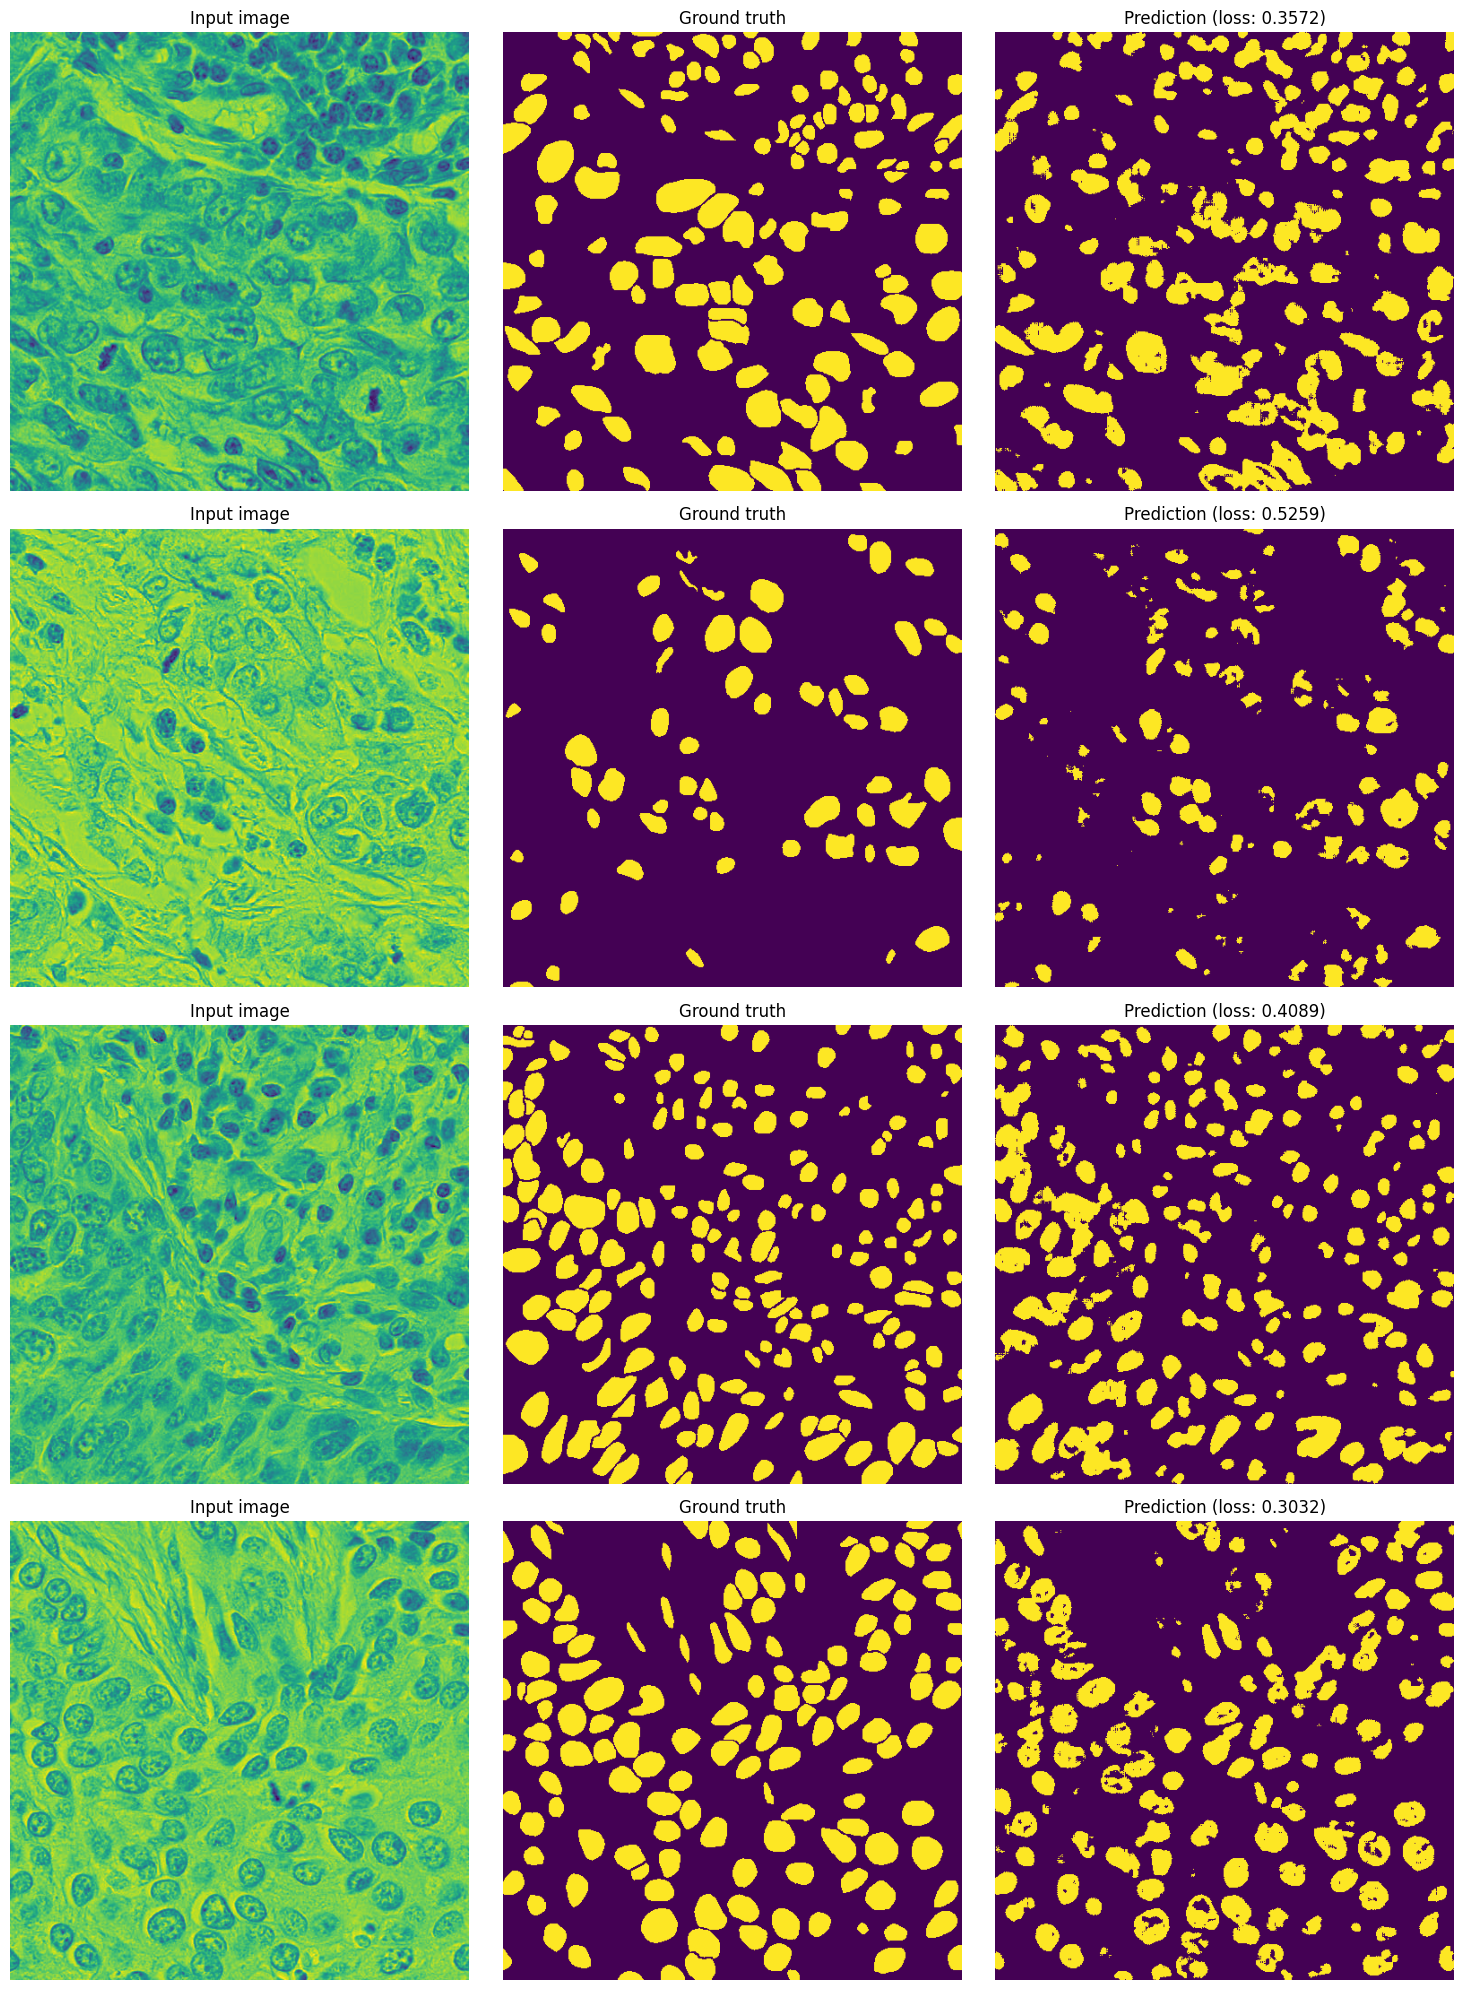

In [18]:
visualize_results(model, test_loader, device, 4)

Train another architecture (either another Unet architecture or find another segmentation model in the available models of Monai). Compare the results with the first model

### Now let's try with the SwinUNETR model from the monai library

In [19]:
from monai.networks.nets import SwinUNETR
from monai.losses import DiceCELoss

In [20]:
def create_swin_unetr():
    return SwinUNETR(
        img_size=(512, 512),
        in_channels=3,
        out_channels=1,
        feature_size=12,  # Further reduced from 12 to 8
        depths=(1, 1, 1, 1),  # Keep minimal depth
        num_heads=(2, 4, 6, 8),  # Further reduced number of heads
        spatial_dims=2,
        drop_rate=0.5,  # Increased dropout
        attn_drop_rate=0.5,  # Increased attention dropout
        normalize=True,
    )

### Training / Evaluation loop

In [21]:
def train_model(model, train_loader, val_loader, loss_function, optimizer, device, num_epochs=30):
    train_losses = []
    val_losses = []

    for epoch in range(30):
        model.train()
        epoch_loss = 0

        # training phase
        for batch_data in train_loader:
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # valid phase
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for batch_data in val_loader:
                inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
                outputs = model(inputs)
                val_loss += loss_function(outputs, labels).item()


        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch + 1}/{num_epochs}:')
        print(f'-> average train_loss: {avg_train_loss:.4f}')
        print(f'-> average val_loss: {avg_val_loss:.4f}\n')

    return train_losses, val_losses

In [22]:
swin_model = create_swin_unetr().to(device)

loss_function = DiceCELoss(sigmoid=True)
optimizer_swin = torch.optim.Adam(swin_model.parameters(), lr=1e-3)

### Training

In [23]:
swin_losses = train_model(swin_model, train_loader, test_loader, loss_function, optimizer_swin, device)

ValueError: the number of dimensions for input and target should be the same, got shape torch.Size([4, 3, 1, 512, 512]) (nb dims: 5) and torch.Size([4, 1, 512, 512]) (nb dims: 4). if target is not one-hot encoded, please provide a tensor with shape B1H[WD].

### Visualization

In [ ]:
visualize_results(swin_model, test_loader, device, 4)

### Comparision between both models

In [28]:
import numpy as np

def plot_training_comparison(unet_losses, swin_losses):
    epochs = range(1, len(unet_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, unet_losses, 'b-', label='UNet train loss')
    plt.plot(epochs, swin_losses, 'r-', label='Swin UNETR train loss')
    plt.title('Model comparison: training loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"UNet - Mean loss: {np.mean(unet_losses):.4f}, std: {np.std(unet_losses):.4f}")
    print(f"Swin - Mean loss: {np.mean(swin_losses):.4f}, std: {np.std(swin_losses):.4f}")
    print(f"Relative improvement: {((unet_losses[-1] - swin_losses[-1])/unet_losses[-1])*100:.2f}%")

In [ ]:
plot_training_comparison(epoch_loss_values, swin_losses[0])

In [30]:
def plot_test_comparison(unet_losses, swin_losses):
    epochs = range(1, len(unet_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, unet_losses, 'b-', label='UNet test loss')
    plt.plot(epochs, swin_losses, 'r-', label='Swin UNETR test loss')
    plt.title('Model comparison: test loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"UNet - Mean loss: {np.mean(unet_losses):.4f}, std: {np.std(unet_losses):.4f}")
    print(f"Swin - Mean loss: {np.mean(swin_losses):.4f}, std: {np.std(swin_losses):.4f}")
    print(f"Relative improvement: {((unet_losses[-1] - swin_losses[-1])/unet_losses[-1])*100:.2f}%")

In [ ]:
plot_test_comparison(epoch_val_losses, swin_losses[1])